# Setup

### Install libraries

In [1]:
!pip install tqdm

import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download(['stopwords', 'punkt'])

Defaulting to user installation because normal site-packages is not writeable
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


[nltk_data] Downloading package stopwords to /home/kinga/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/kinga/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Displaying results of GridSearch

In [1]:
''' source https://www.kaggle.com/grfiv4/displaying-the-results-of-a-grid-search '''

def GridSearch_table_plot(grid_clf, param_name,
                          num_results=15,
                          negative=True,
                          display_all_params=True):

    '''Display grid search results

    Arguments
    ---------

    grid_clf           the estimator resulting from a grid search
                       for example: grid_clf = GridSearchCV( ...

    param_name         a string with the name of the parameter being tested

    num_results        an integer indicating the number of results to display
                       Default: 15

    negative           boolean: should the sign of the score be reversed?
                       scoring = 'neg_log_loss', for instance
                       Default: True

    display_all_params boolean: should we print out all of the parameters, not just the ones searched for?
                       Default: True

    Usage
    -----

    GridSearch_table_plot(grid_clf, "min_samples_leaf")

                          '''
    from matplotlib      import pyplot as plt
    from IPython.display import display
    import pandas as pd

    clf = grid_clf.best_estimator_
    clf_params = grid_clf.best_params_
    if negative:
        clf_score = -grid_clf.best_score_
    else:
        clf_score = grid_clf.best_score_
    clf_stdev = grid_clf.cv_results_['std_test_score'][grid_clf.best_index_]
    cv_results = grid_clf.cv_results_

    print("best parameters: {}".format(clf_params))
    print("best score:      {:0.5f} (+/-{:0.5f})".format(clf_score, clf_stdev))
    if display_all_params:
        import pprint
        pprint.pprint(clf.get_params())

    # pick out the best results
    # =========================
    scores_df = pd.DataFrame(cv_results).sort_values(by='rank_test_score')

    best_row = scores_df.iloc[0, :]
    if negative:
        best_mean = -best_row['mean_test_score']
    else:
        best_mean = best_row['mean_test_score']
    best_stdev = best_row['std_test_score']
    best_param = best_row['param_' + param_name]

    # display the top 'num_results' results
    # =====================================
    display(pd.DataFrame(cv_results) \
            .sort_values(by='rank_test_score').head(num_results))

    # plot the results
    # ================

    if negative:
        means = -scores_df['mean_test_score']
    else:
        means = scores_df['mean_test_score']
    stds = scores_df['std_test_score']
    params = scores_df['param_' + param_name]


### Efficiency measures

In [2]:
from sklearn.metrics import confusion_matrix, accuracy_score, matthews_corrcoef
import matplotlib.pyplot as plt
import seaborn as sns

class Metrics:
    def __init__(self, test_set_y, predictions, method_name, classes):
        self.test_set_y = test_set_y
        self.predictions = predictions
        self.method_name = method_name
        self.classes = classes

    def accuracy(self):
        print('Accuracy Score : ', str(accuracy_score(self.test_set_y, self.predictions)))

    def mcc(self):
        print('MCC : ', str(matthews_corrcoef(self.test_set_y, self.predictions)))

    def confusion_matrix(self):
        cf_matrix_val_purpose = confusion_matrix(self.test_set_y, self.predictions)

        cmn = cf_matrix_val_purpose.astype('float') / cf_matrix_val_purpose.sum(axis=1)[:, np.newaxis]
        perc_labs = ["{0:.1%}".format(value) for value in cmn.flatten()]

        group_counts = ["{0:0.0f}\n".format(value) for value in cf_matrix_val_purpose.flatten()]

        print()
        box_labels = [f"{v1}{v2}".strip() for v1, v2 in zip(group_counts,perc_labs)]
        box_labels = np.asarray(box_labels).reshape(cmn.shape[0],cmn.shape[1])

        fig, ax = plt.subplots(figsize=(6,6))
        sns.heatmap(cmn, annot=box_labels, fmt='', annot_kws={"fontsize":12},
                    xticklabels=list(self.classes), yticklabels=list(classes),
                    cmap='Blues', linecolor='lightgray', linewidths=0.5,
                    square=True, cbar=False, vmin=0, vmax=1)

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.savefig(f'plots/{self.method_name}.pdf')
        plt.show(block=False)
        plt.close()
        
    def all(self):
        print(self.method_name)
        self.accuracy()
        self.mcc()
        self.confusion_matrix()

# Experiment

### Setup commons

In [59]:
gerrit_file = 'gerrit-wireshark-train-test-v4.xlsx'
indexes_file = 'indexes.csv'
indexes_stratified_file = 'indexes_stratified.csv'
seed = 40

### Read dataset
Reads data from excel as a list of dicts with two keys: "message" and "purpose"

In [60]:
import pandas as pd


def read_excel(file_name, sheet_name):
    data = pd.read_excel(file_name, sheet_name=sheet_name, index_col=None, usecols=['message', 'purpose'])
    return data.to_dict(orient='record')


def split_dataset_to_x_y(data_set):
    data_set_x = list([row['message'] for row in data_set])
    data_set_y = list([row['purpose'] for row in data_set])

    return data_set_x, data_set_y


data_set = read_excel(gerrit_file, 'train')

# Map dataset classes

### to 3 classes:

- definitely_worth_discussing -> change_request + discussion_trigger
- maybe_worth_discussing -> discussion_participation
- not_worth_discussing -> the rest

### to 2 classes:
- worth_discussing -> change_request + discussion_trigger
- not_worth_discussing -> pozostale

In [63]:
def map_classes(data_set, nr_of_classes):
    if nr_of_classes == 3:
        for i, element in enumerate(data_set):
            if element['purpose'] == 'change_request' or element['purpose'] == 'discussion_trigger':
                data_set[i]['purpose'] = 'definitely_worth_discussing'
            elif element['purpose'] == 'discussion_participation':
                data_set[i]['purpose'] = 'maybe_worth_discussing'
            else:
                data_set[i]['purpose'] = 'not_worth_discussing'
    elif nr_of_classes == 2:
        for i, element in enumerate(data_set):
            if element['purpose'] == 'change_request' or element['purpose'] == 'discussion_trigger':
                data_set[i]['purpose'] = 'worth_discussing'
            else:
                data_set[i]['purpose'] = 'not_worth_discussing'

    return data_set

data_set = map_classes(data_set, 2)
classes = set(element['purpose'] for element in data_set)

### Generate indexes and save to file
The indexes.csv file has following structure: 
<br>[train_indexes]
<br>[test_indexes]

In [5]:
# import random
# import csv
# import numpy as np
# from sklearn.model_selection import StratifiedShuffleSplit


# def generate_stratified_indexes(index, seed, data_set_x, data_set_y):
#     sss = StratifiedShuffleSplit(n_splits=10, train_size = index, random_state=seed)
#     for train_index, test_index in sss.split(data_set_x, data_set_y):
#         return train_index, test_index

    
# def generate_indexes(length, index, seed, data_set):
#     random.seed(seed)
#     np_array = np.arange(len(data_set))
#     random.shuffle(np_array)
#     split_index = int(index*len(data_set))
#     return np_array[:split_index], np_array[split_index:]


# data_set_x, data_set_y = split_dataset_to_x_y(data_set)
# train_indexes, test_indexes = generate_stratified_indexes(0.9, seed, data_set_x, data_set_y)
# # train_indexes, test_indexes = generate_indexes(len(data_set), 0.9, seed, data_set)
# indexes = [train_indexes, test_indexes]

# with open(indexes_stratified_file, "w", newline="") as f:
#     writer = csv.writer(f)
#     writer.writerows(indexes)

### Prepare training and testing set by
- splitting data according to previously generated to file indexes 
- shuffling data and splitting its randomly

In [64]:
def read_indexes(indexes_file):
    with open(indexes_file, "r", newline="") as f:
        reader = csv.reader(f)
        train_indexes = next(reader)
        test_indexes = next(reader)
        return train_indexes, test_indexes


def split_set_with_indexes(data_set, train_indexes, test_indexes):
    train_set = [data_set[int(i)] for i in train_indexes]
    test_set = [data_set[int(i)] for i in test_indexes]
    return train_set, test_set


train_indexes, test_indexes = read_indexes(indexes_stratified_file)    
train_set, test_set = split_set_with_indexes(data_set, train_indexes, test_indexes)

In [65]:
def split_set_randomly(data_set, index, seed):
    random.seed(seed)
    random.shuffle(data_set)

    split_index = int(index*len(data_set))
    return data_set[:split_index], data_set[split_index:]

# train_set, test_set = split_set_randomly(data_set, 0.9, seed)

### Split dataset to x and y

In [66]:
train_set_x, train_set_y = split_dataset_to_x_y(train_set)
test_set_x, test_set_y = split_dataset_to_x_y(test_set)

## VERSION ONE
## Create BOW representation

In [31]:
import heapq

import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer


def preprocess_data(dataset):
    tokenizer = RegexpTokenizer("[a-zA-Z@]+")
    stemmer = SnowballStemmer("english")
    stop = stopwords.words('english')
    excluding = ['against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shouldn', "shouldn't", 'wasn',
                 "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
                'same', 'here', 'likewise', 'above', 'below']
    stop = [words for words in stop if words not in excluding]

    for index, message in enumerate(dataset):
        message = tokenizer.tokenize(message)
        dataset[index] = " ".join([stemmer.stem(w) for w in message if w not in stop])
    return dataset


def count_words_frequencies(dataset):
    frequencies = {}
    for message in dataset:
        words = nltk.word_tokenize(message)
        for word in words:
            if word not in frequencies.keys():
                frequencies[word] = 1
            else:
                frequencies[word] += 1
    return frequencies


def create_vector(messages, frequent_words):
    bow_model = []
    for message in messages:
        vector = []
        for word in frequent_words:
            if word in nltk.word_tokenize(message):
                vector.append(1)
            else:
                vector.append(0)
        bow_model.append(vector)
    return np.asarray(bow_model)


def create_bow_model(data_set_x, frequent_words_count):
    data_set_x = preprocess_data(data_set_x)
    word_frequencies = count_words_frequencies(data_set_x)
    frequent_words = heapq.nlargest(frequent_words_count, word_frequencies, key=word_frequencies.get)
    bow_model = create_vector(data_set_x, frequent_words)
    return bow_model


frequent_words_count = 100
train_bow_model = create_bow_model(train_set_x, frequent_words_count)
test_bow_model = create_bow_model(test_set_x, frequent_words_count)

### Create classifiers

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier


class Classifier:
    def __init__(self, seed, train_bow_model, train_set_y, test_bow_model, test_set_y):
        self.seed = seed
        self.train_bow_model = train_bow_model
        self.train_set_y = train_set_y
        self.test_bow_model = test_bow_model
        self.test_set_y = test_set_y
    
    def logistic_regression(self):
        log_reg = LogisticRegression(random_state=self.seed, 
                                     multi_class='ovr', 
                                     penalty='l2',
                                     max_iter=1000000, 
                                     class_weight='balanced', 
                                     solver='lbfgs', C=1)
        log_reg.fit(self.train_bow_model, self.train_set_y)
        return log_reg.predict(self.test_bow_model)
        
    def grid_search_logistic_regression(self):
        param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100],
                      'solver': ['liblinear', 'newton-cg', 'sag', 'saga', 'lbfgs']}
        grid_search = GridSearchCV(LogisticRegression(random_state=self.seed, max_iter=1000000,
                                                     class_weight='balanced'), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "C", negative=False)

    def random_forest(self, estimators_number):
        rfc = RandomForestClassifier(estimators_number, 
                                     random_state=self.seed,
                                     class_weight='balanced')
        rfc.fit(self.train_bow_model, self.train_set_y)
        return rfc.predict(self.test_bow_model)
        
    def grid_search_random_forest(self):
        param_grid = {'n_estimators': [1, 10, 100, 1000]}
        grid_search = GridSearchCV(RandomForestClassifier(random_state=self.seed), param_grid, verbose=1)
        grid_search.fit(self.train_bow_model, self.train_set_y)
        predictions = grid_search.predict(self.test_bow_model)
        GridSearch_table_plot(grid_search, "n_estimators", graph=False, negative=False)

    def decision_tree(self):
        decision_tree = DecisionTreeClassifier(random_state=self.seed, 
                                               splitter='random', 
                                               class_weight='balanced')
        decision_tree.fit(self.train_bow_model, self.train_set_y)
        return decision_tree.predict(self.test_bow_model)

logistic_regression
Accuracy Score :  0.7
MCC :  0.36872915045497834



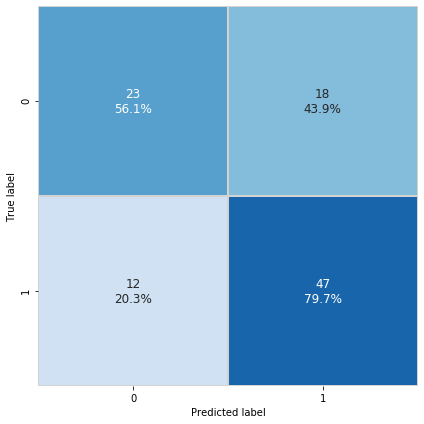

random_forest
Accuracy Score :  0.7
MCC :  0.3631716515334615



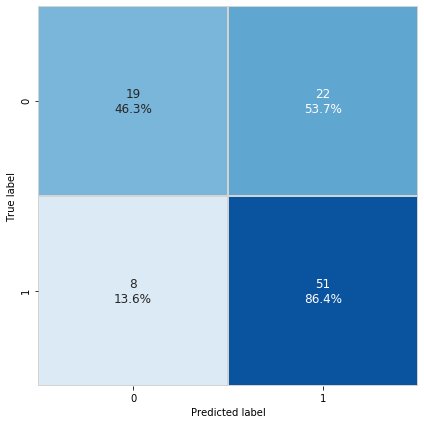

decision_tree
Accuracy Score :  0.68
MCC :  0.3297408029234883



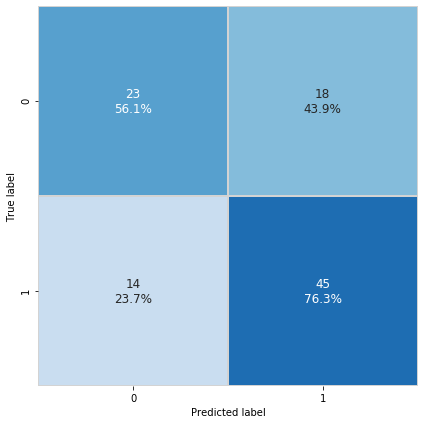

In [33]:
classifier = Classifier(seed, train_bow_model, train_set_y, test_bow_model, test_set_y)

predictions = classifier.logistic_regression()
metrics = Metrics(test_set_y, predictions, 'logistic_regression', classes)
metrics.all()

predictions = classifier.random_forest(100)
metrics = Metrics(test_set_y, predictions, 'random_forest', classes)
metrics.all()

predictions = classifier.decision_tree()
metrics = Metrics(test_set_y, predictions, 'decision_tree', classes)
metrics.all()

## VERSION TWO
## Create WE representation

### Load pre-trained StackOverflow WE model
Requires the 'SO_vectors_200.bin' file in current directory. Download here: https://zenodo.org/record/1199620#.XsRAw-GxW0k

In [33]:
from gensim.models.keyedvectors import KeyedVectors

word_vect = KeyedVectors.load_word2vec_format("SO_vectors_200.bin", binary=True)

### Utils for WE model

In [67]:
import heapq

import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from gensim.models import Word2Vec


def preprocess_data(data_set):
    tokenizer = RegexpTokenizer("[a-zA-Z@]+")
    stemmer = SnowballStemmer("english")
    stop = stopwords.words('english')
    excluding = ['against', 'not', 'don', "don't", 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
                 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
                 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shouldn', "shouldn't", 'wasn',
                 "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't",
                'same', 'here', 'likewise', 'above', 'below']
    stop = [word for word in stop if word not in excluding]

    tokenized_data = []
    for message in data_set:
        message = tokenizer.tokenize(message)
        tokenized_data.append([stemmer.stem(w) for w in message if w not in stop])
    return tokenized_data


def get_mean_vector(we_model, comment):
    words_in_we = [word for word in comment if word in we_model.vocab]
    if len(words_in_we) >= 1:
        return np.mean(we_model[words_in_we], axis=0)
    else:
        return []
    

def get_mean_vectors(data_set_x, data_set_y):
    indexes_to_remove = []
    data_set_vectors = []
    for index, comment in enumerate(data_set_x):
        vec = get_mean_vector(word_vect, comment)
        if len(vec) > 0:
            data_set_vectors.append(vec)
        else:
            indexes_to_remove.append(index)

    indexes_to_remove.sort(reverse=True)
    for index in indexes_to_remove:
        data_set_y.pop(index)
    return data_set_vectors

### Convert comments to mean vectors
Each comment is converted to a vector which is a mean of all vectors of words in that comment. If a comment consists of words from outside the model, they are removed. If the whole comment is made of such words, the pair of (comment, purpose) is removed from x_set and y_set respectively.

In [68]:
train_set_x_tokenized = preprocess_data(train_set_x)
train_set_vectors = get_mean_vectors(train_set_x_tokenized, train_set_y)

test_set_x_tokenized = preprocess_data(test_set_x)
test_set_vectors = get_mean_vectors(test_set_x_tokenized, test_set_y)

### Convert data set arrays into NumPy arrays 
required for future Keras model training

In [69]:
X = np.array(train_set_vectors)
Y = np.array(train_set_y)

X_test = np.array(test_set_vectors)
Y_test = np.array(test_set_y)

In [70]:
Y = preprocessing.LabelEncoder().fit_transform(Y)
Y_test = preprocessing.LabelEncoder().fit_transform(Y_test)

## LSTM model

99/99 [==============================] - 0s 11us/step
loss, accuracy: [0.504554271697998, 0.7878788113594055]
WE_LSTM
Accuracy Score :  0.7878787878787878
MCC :  0.5531113842526029



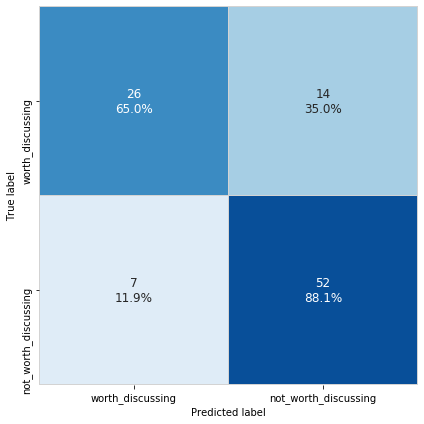

In [75]:
from keras.models import Sequential
from keras.layers import Dense, GRU
from keras.layers import LSTM
from keras.layers.embeddings import Embedding

model = Sequential()
model.add(Dense(200, activation='relu', input_dim=200))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.fit(X, Y, epochs=30, batch_size=64, verbose=0, validation_split=0.1)

results = model.evaluate(X_test, Y_test, batch_size=128)
print('loss, accuracy:', results)

predictions = model.predict(X_test)
predictions = [np.rint(prediction) for prediction in predictions]

metrics = Metrics(Y_test, predictions, 'WE_LSTM', classes)
metrics.all()